In [ ]:
import gymnasium as gym
import ale_py
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
tf.keras.utils.disable_interactive_logging()
import re

c:\Users\15047\anaconda3\envs\virtual_maid\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\15047\anaconda3\envs\virtual_maid\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\15047\anaconda3\envs\virtual_maid\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\15047\anaconda3\envs\virtual_maid\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [123]:
# Define DQN
class DQN:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []
        self.gamma = 0.90  # Discount factor
        self.epsilon = 1.0  # ε
        self.epsilon_decay = 0.99  # ε decay
        self.epsilon_min = 0.01  # min epsilon
        self.learning_rate = 0.005
        self.model = self._build_model()

    # build neuro network
    def _build_model(self):
        model = Sequential()
        model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(210, 160, 3)))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(layers.Flatten())
        model.add(layers.Dense(64, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    # save experience
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # Choose decision using ε-greedy
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        else:
            if np.shape(state)==(210, 160, 3):
                state=tf.expand_dims(state,axis=0)
            if np.shape(state) == (2,):
                state=tf.expand_dims(state[0],axis=0)
            q_values = self.model.predict(state,verbose=0)
            return np.argmax(q_values[0])

    # training neuro network
    def train(self, batch_size):
        minibatch = np.random.choice(len(self.memory), batch_size, replace=False)
        for i in minibatch:
            state, action, reward, next_state, done = self.memory[i]
            target = reward
            if not done:
                # predict next q value
                next_state = np.array([next_state])
                next_q_values = self.model.predict(next_state)[0]
                target = reward + self.gamma * np.amax(next_q_values)
            # update current q value
            if np.shape(state)==(210, 160, 3):
                state=tf.expand_dims(state,axis=0)
            if np.shape(state) == (2,):
                state=tf.expand_dims(state[0],axis=0)
            q_values = self.model.predict(state)
            q_values[0][action] = target
            self.model.fit(state, q_values, epochs=1, verbose=0)
        # drop epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay



In [ ]:
# build environment
env = gym.make("ALE/Breakout-v5",render_mode="rgb_array")
state_size = 100800
action_size = env.action_space.n
dqn = DQN(state_size, action_size)

num_episodes = 300
batch_size = 16

for episode in range(num_episodes):
    state = env.reset()

    for step in range(1000):  # max 1000steps/epoch
        action = dqn.act(state)
        next_state, reward, done, _,_ = env.step(action)
        dqn.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            break

    if len(dqn.memory) > batch_size:
        dqn.train(batch_size)

    if episode % 25 == 0:
        print("Episode: {}, Steps: {}, Epsilon: {:.2f}".format(episode, step, dqn.epsilon))
env.close()

env = gym.wrappers.RecordVideo(env, video_folder="./save_videos2", episode_trigger=lambda x: x%10==0, disable_logger=True)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=10000)

In [ ]:
for episode in range(num_episodes):
    state = env.reset()

    for step in range(1000):  # max 1000steps/epoch
        action = dqn.act(state)
        next_state, reward, done, _,_ = env.step(action)
        dqn.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            break

    if len(dqn.memory) > batch_size:
        dqn.train(batch_size)

    if episode % 25 == 0:
        print("Episode: {}, Steps: {}, Epsilon: {:.2f}".format(episode, step, dqn.epsilon))
env.close()



c:\Users\15047\anaconda3\envs\virtual_maid\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Episode: 0, Steps: 122, Epsilon: 0.05
Episode: 25, Steps: 121, Epsilon: 0.04
Episode: 50, Steps: 838, Epsilon: 0.03
Episode: 75, Steps: 121, Epsilon: 0.02


: 

In [ ]:
print(f'Episode time taken: {env.time_queue}')
print(f'Episode total rewards: {env.return_queue}')
print(f'Episode lengths: {env.length_queue}')
with open('time.txt','w') as o:
    o.write(str(env.time_queue))
with open('return.txt','w') as po:
    po.write(str(env.return_queue))
with open('length.txt','w') as p:
    p.write(str(env.length_queue))

Episode time taken: deque([0.121539, 0.181922, 0.123323, 0.325887, 0.274698, 0.635259, 0.327602, 0.808311, 0.68139, 0.762536, 0.852053, 0.906184, 0.65291, 0.895771, 0.697638, 1.003798, 1.374582, 2.433987, 1.281646, 1.455785, 0.807191, 1.446499, 1.579119, 1.028139, 1.984379, 1.612927, 1.38788, 1.730454, 2.784952, 1.770336, 2.905311, 2.133195, 3.480105, 2.355618, 1.884393, 2.285933, 2.983824, 2.404835, 2.20058, 2.444771, 2.871691, 1.788358, 2.81553, 2.283072, 2.827934, 3.267014, 1.944493, 2.833633, 5.105024, 2.163552, 2.292678, 4.373973, 3.422975, 2.200839, 4.543706, 4.258445, 3.310386, 4.257917, 6.033512, 3.843869, 5.329717, 3.128985, 5.789071, 4.892273, 2.764526, 3.452049, 3.193908, 3.755264, 3.055463, 3.153122, 2.764504, 3.843586, 3.820186, 5.622107, 4.821344, 3.623678, 4.003382, 3.354232, 4.412749, 3.576219, 4.167222, 5.102265, 4.626812, 4.733395, 4.361625, 3.646198, 3.353248, 6.546975, 5.558294, 7.163266, 12.211233, 9.098953, 5.43481, 6.592557, 5.53582, 7.037929, 5.085321, 11.173025

In [ ]:
import re

time = open('time.txt','r')
t =time.read()
returns = open('return.txt','r')
r = returns.read()
length = open('length.txt','r')
l = length.read()

t = re.findall("\[.*\]",t)[0].replace("[","")
t = t.replace(']','')
t =[float(i.strip()) for i in t.split(',')]
r = re.findall("\[.*\]",r)[0].replace("[","")
r = r.replace(']','')
r =[float(i.strip()) for i in r.split(',')]
l = re.findall("\[.*\]",l)[0].replace("[","")
l = l.replace(']','')
l =[float(i.strip()) for i in l.split(',')]

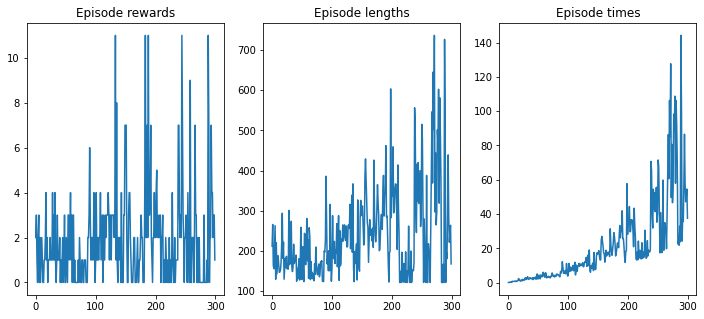

In [33]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
axs[0].plot(range(len(r)),r)
axs[1].set_title("Episode lengths")
axs[1].plot(range(len(l)),l)
axs[2].set_title("Episode times")
axs[2].plot(range(len(t)),t)
fig.savefig('rslt.png')